# Prepare data for the training / validation of the GP and NN system model

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Load data and pre-process data

- We load the previously created training data (100 sequences of MPC controlled towing kite)
- In post processing, we retrieve the following sequences from the ``do_mpc.data.Data`` object:
    - states
    - inputs
    - tether force
    - kite height
- We filter out sequences that did not converge (some inital conditions were poorly chosen) based on critera ``T_f > 1e6``.
- We filter out sequences with very large or very small values of ``w_ref`` and ``E_0``

In [2]:
%%capture 

plans = []

names = ['kite_sampling_01']

dh_list = []
res = []
for name in names:
    load_name = '../sampling/{name}/{name}_plan.pkl'.format(name=name)
    plan = do_mpc.tools.load_pickle(load_name)
    
    dh = do_mpc.sampling.DataHandler(plan)
    dh.set_param(data_dir = '../sampling/{}/sample_results/'.format(name))

    dh.set_post_processing('input', lambda data: data['_u'])
    dh.set_post_processing('states', lambda data: data['_x'])
    dh.set_post_processing('wind', lambda data: data['_p'])
    dh.set_post_processing('T_F', lambda data: data['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data['_x'].shape[0])
    dh_list.extend(dh)
    res.extend(dh.filter(input_filter = lambda w_ref, E_0: np.abs(w_ref-10)<2 and np.abs(E_0-6)<2,
                        output_filter = lambda T_F: np.sum(T_F)/1e6>20))




In [3]:
print(f'After filtering we still have {len(res)} / 100 sequences.')

After filtering we still have 38 / 100 sequences.


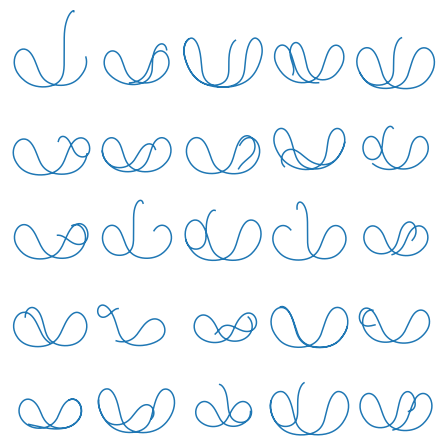

In [4]:
n_res = min(len(res),25)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(6,6))
for i, res_i in enumerate(res[:n_res]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0])
    ax[i//n_col, np.mod(i,n_col)].axis('off')

    
fig.tight_layout(pad=0)



## Create training, test and validation data

For testing purposes, we set aside a fixed number of sequences that are not using for training.

With the remaining sequences we prepare our input and output data for the neural network.
This data is then randomly partitioned into (10%) validation and (90%) training data.

In [10]:
model_in = []
model_out = []

# Choose number of sequences reserved for testing (use the remaining sequences for train/validation data)
n_test = 20
train_val_res = res[:-n_test]
test_res = res[-n_test:]


# For all sequences used for training/validation:
for i, res_i in enumerate(train_val_res):
    x_now = res_i['states'][:,:] 

    model_in.append(np.concatenate((res_i['input'], res_i['wind'], x_now),axis=1)[:-1,:])

    x_next = np.roll(res_i['states'],-1,axis=0)[:,:]
    dx = x_next - x_now

    model_out.append(np.concatenate((res_i['T_F'], res_i['height'], dx),axis=1)[:-1,:])

# Concatenate input and output to a single array.    
model_in = np.concatenate(model_in)
model_out = np.concatenate(model_out)

# Split in train and test data
data_split = train_test_split(model_in, model_out, test_size=0.1, random_state=42)

in_train = data_split[0]
in_test = data_split[1]
out_train = data_split[2]
out_test = data_split[3]

## Scale data

In [13]:
in_scaler = preprocessing.StandardScaler().fit(in_train)
out_scaler = preprocessing.StandardScaler().fit(out_train)

in_train_scaled = in_scaler.transform(nn_in_train)
out_train_scaled = out_scaler.transform(nn_out_train)

in_test_scaled = in_scaler.transform(nn_in_test)
out_test_scaled = out_scaler.transform(nn_out_test)

Some information about the data:

In [16]:
print(f'We have m = {in_train_scaled.shape[0]} training samples')
print(f'We have {in_test_scaled.shape[0]} testing samples')

print(f'We have n_x = {in_train_scaled.shape[1]} inputs.')
print(f'We have n_y = {out_train_scaled.shape[1]} outputs.')

We have m = 3223 training samples
We have 359 testing samples
We have n_x = 6 inputs.
We have n_y = 5 outputs.


# Export

Export the prepared data to be used for the training of the GP and NN.

In [20]:
export_bool = True

if export_bool:
    export_name = 'S01_Prep_01'
    export_path = './data_prep/'
    pathlib.Path(export_path.format(export_name)).mkdir(parents=True, exist_ok=True)

    export_dict = {'in_train_scaled': in_train_scaled, 'in_test_scaled': in_test_scaled, 
                   'out_train_scaled': out_train_scaled, 'out_test_scaled': out_test_scaled,
                   'in_scaler': in_scaler, 'out_scaler': out_scaler,
                  'test_res': test_res}
    do_mpc.tools.save_pickle(export_path + export_name + '.pkl', export_dict)